# **DACON - 버스 운행시간 예측 경진대회**
목표 : 제주도 버스의 효율적인 운행를 위해 운행 시간을 예측하는 모델 생성

- 교통
- 공공 교통 위치 빅데이터와 AI로 버스 운행 시간 분석
- 회귀, RMSE

## **data**

* (train, test csv)

해당 날짜 별, 노선 및 버스 ID가 주어진 상황에서 현재 정류소의 이름과 현재 정류장 도착 시간을 이용하여,

다음 정류장에 도착할 때까지 걸리는 시간을 예측하기 위한 데이터를 제공해 드립니다.

## **columns**

**train.csv and test.csv**
* id : 해당 데이터에서의 고유한 ID(train, test와의 중복은 없음)
* date : 날짜
* route_id : 버스 노선ID
* vh_id : 버스 ID
* route_nm : 버스 노선 실제 번호
* now_latitude : 현재 정류소의 위도 
* now_longitude : 현재 정류소의 경도
* now_station : 현재 정류소 이름
* now_arrive_time : 현재 정류장에 도착한 시간
* distance : 현재 정류장에서 다음 정류장까지 실제 이동한 거리
* next_station : 다음 정류소 이름
* next_latitude : 다음 정류소의 위도
* next_longitude : 다음 정류소의 경도
* next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값

**submission_제출양식.csv**
* id : test.csv에서의 고유한 ID
* next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위 : 초)으로 답안 제출을 위해서 예측 해야 되는 값

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import zipfile
         
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/DACON/data/data12.zip') as existing_zip:
  existing_zip.extractall()

In [95]:
import pandas as pd

train_df = pd.read_csv('train.csv') 
train_df.head(5)

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [97]:
# date column을 pandas의 datetime 타입으로 변경
train_df['date'] = train_df.date.apply(pd.to_datetime)

# datetime 타입에서 년,월,일,시간 추출
train_df['year']=train_df.date.apply(lambda x:x.year)
train_df['month']=train_df.date.apply(lambda x:x.month)
train_df['day']=train_df.date.apply(lambda x:x.day)

# now_arrive_time 을 int형으로 변경
train_df['now_arrive_time']=train_df.now_arrive_time.str.split('시').str[0]
train_df['now_arrive_time']=pd.to_numeric(train_df['now_arrive_time'])

# day칼럼을 휴일이면 0, 평일이면 1로 categorical로 변경
train_df.loc[train_df['day'].isin([19,20,26,27]), 'day'] = 0
train_df.loc[train_df['day'].isin([19,20,26,27])==False, 'day'] = 1
train_df.head()

# year, month칼럼은 모두 2019년 10월로 공통값이므로 drop
drop_columns=['date', 'year', 'month']
train_df.drop(drop_columns, axis=1,inplace=True)

In [98]:
train_df.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,day
0,0,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,6,266.0,제대마을,33.457724,126.554014,24,1
1,1,405136001,7997025,360-1,33.457724,126.554014,제대마을,6,333.0,제대아파트,33.458783,126.557353,36,1
2,2,405136001,7997025,360-1,33.458783,126.557353,제대아파트,6,415.0,제주대학교,33.459893,126.561624,40,1
3,3,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,1
4,4,405136001,7997025,360-1,33.485662,126.494923,도호동,7,374.0,은남동,33.485822,126.490897,64,1


In [99]:
tdf_sample= train_df.sample(10000)
tdf_sample.index

Int64Index([  9461,  39743,  74528,  69782,  44019,  67211,  32706, 108146,
            205267, 189671,
            ...
               746,  61175, 115261, 106486,  50165, 201471,  64925,  20676,
             99735,  16412],
           dtype='int64', length=10000)

In [100]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map([lat_m, long_m],zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for i in tdf_sample.index:
  sub_lat = tdf_sample.loc[i, "now_latitude"]
  sub_long = tdf_sample.loc[i, "now_longitude"]

  title = tdf_sample.loc[i, "now_station"]

  folium.CircleMarker(
      [sub_lat,sub_long ], 
      radius=5,
      color="blue",
      popup=f'<i>{title}</i>', 
      tooltip=title).add_to(marker_cluster)

m

Output hidden; open in https://colab.research.google.com to view.

## 예측 성능 평가 함수
캐글에서 요구한 성능 평가 방법 : RMSE(Root Mean Square Error)

+MAE, RMSLE까지 한꺼번에 평가하는 함수 추가작성

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가
회귀 모델 적용 전 처리할 사항

결과 값이 정규 분포로 되어있는지 확인
카테고리형 회귀 모델의 경우 원ㅡ핫 인코딩으로 피처 인코딩

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = train_df['next_arrive_time']
X_features = train_df.drop(['next_arrive_time'],axis=1,inplace=False) # inplace=False 주의

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 0.531, RMSE: 74.948, MAE: 35.755


In [ ]:
# 실제 값과 예측값이 어느정도 차이가 나는지 dataframe의 칼럼으로 만들어서 확인
# 오류값이 가장 큰 순으로 5개만 확인할 것임
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_time']) # dataframe만들고 실제값 칼럼 추가
    result_df['predicted_time']=np.round(pred) # 예측값 칼럼 추가
    result_df['diff']=np.abs(result_df['real_time']-result_df['predicted_time']) # 크기 차이만 본다
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops]) # 5개만 내림차순으로 확인

get_top_error_data(y_test, pred, n_tops=5)

       real_time  predicted_time    diff
58715       2870           101.0  2769.0
43767       2812           100.0  2712.0
1698        2642            47.0  2595.0
61464       2674           114.0  2560.0
19816       2644            97.0  2547.0


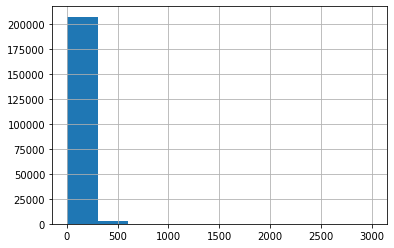

In [ ]:
y_target.hist()

* next_arrive_time값이 왜곡됨
* 왜곡된 값 -> 정규분포로 바꾸는 방법은 "로그 변환"
* log1p()이용 후 학습 -> expm1()로 원상 복구

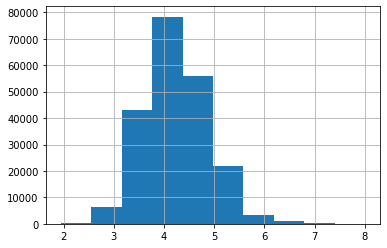

In [ ]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [ ]:
# 타겟 칼럼인 next_arrive_time값을 log1p로 로그변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target값이 로그 변환 됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값도 마찬가지
pred_exp = np.expm1(pred)


In [ ]:
evaluate_regr(y_test_exp, pred_exp)

RMSLE: 0.529, RMSE: 121.785, MAE: 40.052


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


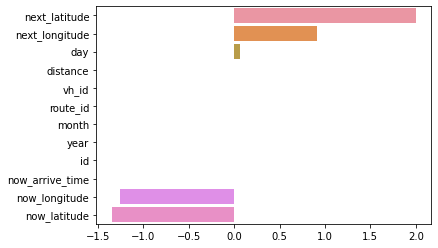

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 각 피처의 회귀 계수 값을 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)